## Sentinel Hub / Xcube Integration Demo - BYOD
* On-the-fly access to any SentinelHub bring-your-own-data (BYOD) datasets
* Visualising RGB data

For setup info see [demo-sh.ipynb](./demo-sh.ipynb).

In [1]:
import json

import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [2]:
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.geodb import GeoDB
from xcube_sh.viewer import ViewerServer

In [3]:
%matplotlib inline

---
Ljubljana area using Web Mercator coordinates:

In [4]:
x1 = 1545577  # meters
y1 = 5761986  # meters
x2 = 1705367  # meters
y2 = 5857046  # meters

bbox = x1, y1, x2, y2

In [5]:
geom = shapely.geometry.box(*bbox)

In [6]:
import functools
import pyproj
import shapely.ops

project = functools.partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'),  # source coordinate system (Web Mercator)
    pyproj.Proj(init='epsg:4326'))  # destination coordinate system (WGS-84)

geom_wgs84 = shapely.ops.transform(project, geom)  # apply projection
IPython.display.GeoJSON(geom_wgs84.__geo_interface__)

<IPython.display.GeoJSON object>

We compute the desired resolution by the width in pixels and the given max. extent:

In [7]:
width = 512
spatial_res = (x2 - x1) / width
height = max(1, round((y2 - y1) / spatial_res))

In [8]:
cube_config = CubeConfig(dataset_name='CUSTOM',
                         band_names=['RED', 'GREEN', 'BLUE'],                        
                         chunk_size=[width, height],
                         crs='http://www.opengis.net/def/crs/EPSG/0/3857',
                         geometry=bbox,
                         time_range=['2018-01-01', '2019-01-01'],
                         time_period='1y',
                         spatial_res=spatial_res,
                         band_sample_types='UINT8',
                         collection_id='1a3ab057-3c51-447c-9f85-27d4b633b3f5')

In [9]:
# So we can print some SentinelHub usage stats
request_collector = Observers.request_collector()

In [12]:
cube = open_cube(cube_config, request_collector)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 1, x: 512, y: 305)
Coordinates:
  * time       (time) datetime64[ns] 2018-07-02T14:54:36
    time_bnds  (time, bnds) datetime64[ns] dask.array<shape=(1, 2), chunksize=(1, 2)>
  * x          (x) float64 1.546e+06 1.546e+06 1.546e+06 ... 1.705e+06 1.705e+06
  * y          (y) float64 5.857e+06 5.857e+06 5.856e+06 ... 5.762e+06 5.762e+06
Dimensions without coordinates: bnds
Data variables:
    BLUE       (time, y, x) uint8 dask.array<shape=(1, 305, 512), chunksize=(1, 305, 512)>
    GREEN      (time, y, x) uint8 dask.array<shape=(1, 305, 512), chunksize=(1, 305, 512)>
    RED        (time, y, x) uint8 dask.array<shape=(1, 305, 512), chunksize=(1, 305, 512)>
Attributes:
    Conventions:               CF-1.7
    title:                     CUSTOM Data Cube Subset
    history:                   [{'program': 'xcube_sh.store.SentinelHubStore'...
    date_created:              2019-11-05T16:37:33.103196
    processing_level:          None
    time_

In [13]:
cube.RED

<xarray.DataArray 'RED' (time: 1, y: 305, x: 512)>
dask.array<shape=(1, 305, 512), dtype=uint8, chunksize=(1, 305, 512)>
Coordinates:
  * time     (time) datetime64[ns] 2018-07-02T14:54:36
  * x        (x) float64 1.546e+06 1.546e+06 1.546e+06 ... 1.705e+06 1.705e+06
  * y        (y) float64 5.857e+06 5.857e+06 5.856e+06 ... 5.762e+06 5.762e+06

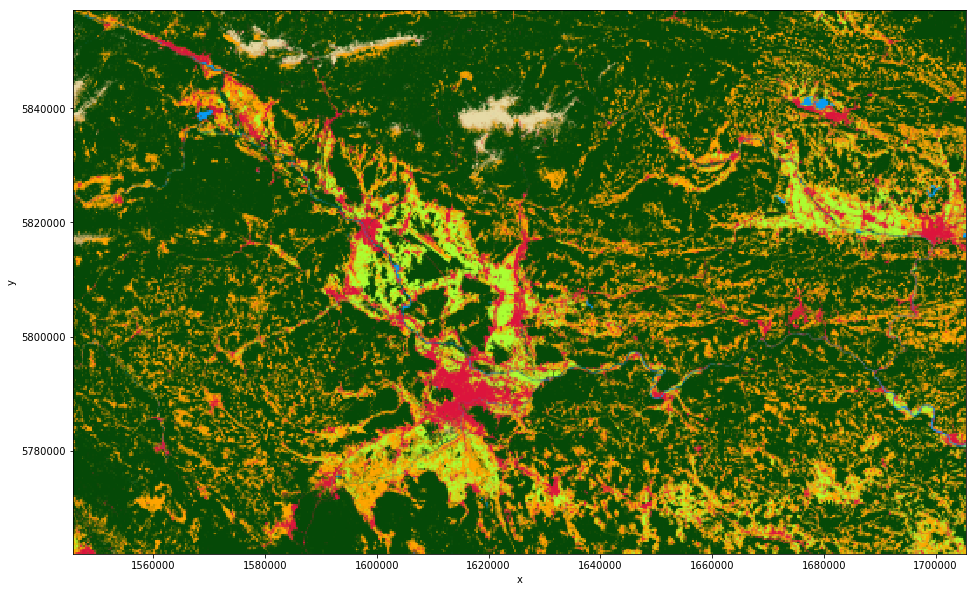

In [14]:
import numpy as np

rgb_data = np.zeros((305, 512, 3), 'uint8')
rgb_data[:, :, 0] = cube.RED.values
rgb_data[:, :, 1] = cube.GREEN.values
rgb_data[:, :, 2] = cube.BLUE.values

rgb_array = xr.DataArray(rgb_data, dims=('y', 'x', 'b'), coords=dict(x=cube.RED.x, y=cube.RED.y))
rgb_array.plot.imshow(rgb='b', figsize=(16, 10))

In [15]:
request_collector.stats

Number of requests:,3
Request duration min:,539.32 ms
Request duration max:,1261.89 ms
Request duration median:,816.10 ms
Request duration mean:,872.44 ms
Request duration std:,297.67 ms
